In [1]:
import rasterio
from rasterio.enums import Resampling
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
from rasterio.plot import show

In [2]:
raw_dir = "tehri_landslide/data/sentinel_raw/"
resampled_dir = "tehri_landslide/data/sentinel_resampled/"
clipped_dir = "tehri_landslide/data/sentinel_clipped/"
stack_path = "tehri_landslide/data/sentinel_stacked/tehri_stack.tif"
shapefile_path = "Tehri_bound/tehri_boundary.shp"

In [3]:
bands_10m = ["B02", "B03", "B04", "B08"]
bands_20m = ["B11", "B12"]
target_res = 10 

In [4]:
boundary = gpd.read_file(shapefile_path)

In [5]:
def resample_band(in_path, out_path, scale_factor=2):
    with rasterio.open(in_path) as src:
        data = src.read(
            out_shape=(src.count,
                       int(src.height * scale_factor),
                       int(src.width * scale_factor)),
            resampling=Resampling.bilinear
        )
        transform = src.transform * src.transform.scale(
            src.width / data.shape[-1],
            src.height / data.shape[-2]
        )
        profile = src.profile
        profile.update(transform=transform,
                       width=data.shape[-1],
                       height=data.shape[-2])
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(data)

In [6]:
for band in bands_20m:
    jp2_files = [f for f in os.listdir(raw_dir) if f"_"+band+"_" in f and f.endswith(".jp2")]
    for file in jp2_files:
        in_path = os.path.join(raw_dir, file)
        out_path = os.path.join(resampled_dir, file.replace(".jp2", "_resampled10m.tif"))
        resample_band(in_path, out_path)

In [7]:
boundary_path = "tehri_landslide/data/Tehri_boundary/tehri_boundary.shp"
band_path = "tehri_landslide/data/sentinel_resampled/T44RKU_20250403T052649_B11_20m_resampled10m.tif"

# Open and check CRS
boundary = gpd.read_file(boundary_path)
with rasterio.open(band_path) as src:
    raster_crs = src.crs

print("Boundary CRS:", boundary.crs)
print("Raster CRS:", raster_crs)

Boundary CRS: EPSG:4326
Raster CRS: EPSG:32644


In [8]:
boundary = boundary.to_crs(raster_crs)

In [9]:
all_bands = bands_10m + bands_20m
clipped_bands = []

for band in all_bands:
    if band in bands_10m:
        files = [f for f in os.listdir(raw_dir) if f"_{band}_" in f and f.endswith(".jp2")]
        band_path = os.path.join(raw_dir, files[0])
    else:
        files = [f for f in os.listdir(resampled_dir) if f"_{band}_" in f and f.endswith(".tif")]
        band_path = os.path.join(resampled_dir, files[0])

    with rasterio.open(band_path) as src:
        out_image, out_transform = mask(src, boundary.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        out_path = os.path.join(clipped_dir, f"{band}_clipped.tif")
        with rasterio.open(out_path, "w", **out_meta) as dest:
            dest.write(out_image)
        clipped_bands.append(out_path)

In [10]:
boundary_path = "tehri_landslide/data/Tehri_boundary/tehri_boundary.shp"
clipped_path = "tehri_landslide/data/sentinel_clipped/B11_clipped.tif"

# Read data
boundary = gpd.read_file(boundary_path)

# Read raster
src = rasterio.open(clipped_path)

# Match CRS (just to be sure)
boundary = boundary.to_crs(src.crs)

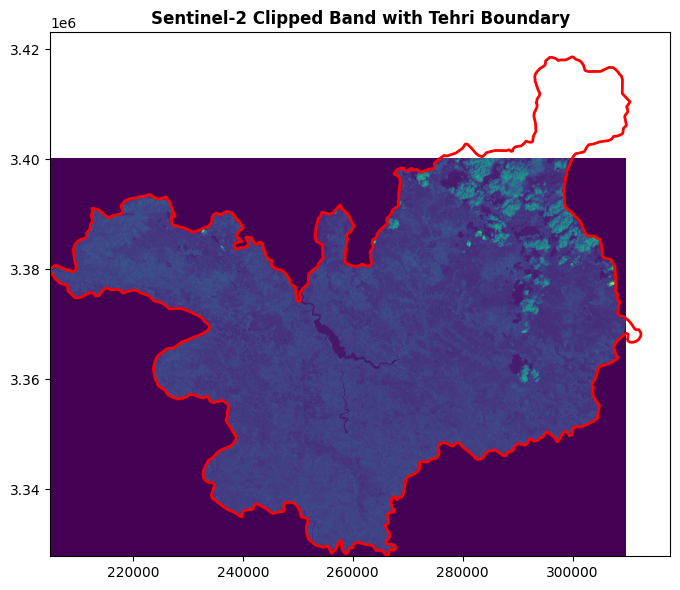

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
show(src, ax=ax, title="Sentinel-2 Clipped Band with Tehri Boundary")
boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
plt.show()

In [12]:
arrays = []
meta = None
for path in clipped_bands:
    with rasterio.open(path) as src:
        arrays.append(src.read(1))
        if meta is None:
            meta = src.meta.copy()

stacked = np.stack(arrays)

meta.update({
    "count": len(clipped_bands),
    "driver": "GTiff"
})

with rasterio.open(stack_path, "w", **meta) as dst:
    dst.write(stacked)

print(f"Stacked raster created at: {stack_path}")

Stacked raster created at: tehri_landslide/data/sentinel_stacked/tehri_stack.tif


In [14]:
with rasterio.open("tehri_landslide/data/sentinel_stacked/tehri_stack.tif") as src:
    print("Band count:", src.count)
    print("Descriptions:", src.descriptions)


Band count: 6
Descriptions: (None, None, None, None, None, None)


In [16]:
stack_path = "tehri_landslide/data/sentinel_stacked/tehri_stack.tif"

In [17]:
with rasterio.open(stack_path, "w", **meta) as dst:
    dst.write(stacked)


In [19]:
with rasterio.open(stack_path, "w", **meta) as dst:
    dst.write(stacked)

    band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
    for i, name in enumerate(band_names, start=1):
        dst.set_band_description(i, name)

In [23]:
with rasterio.open(stack_path) as src:
    print(src.descriptions)

('B02', 'B03', 'B04', 'B08', 'B11', 'B12')


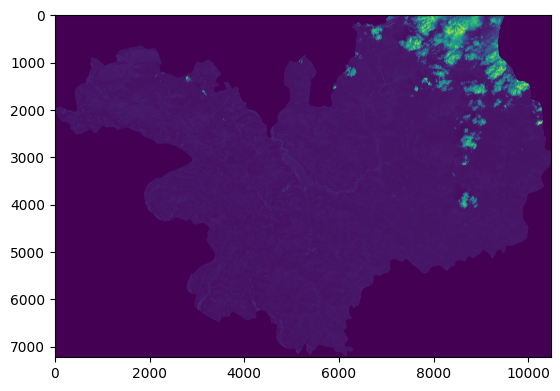

In [25]:
import matplotlib.pyplot as plt
plt.imshow(stacked[0])
plt.show()
